# **Imports**

In [25]:
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import numpy as np
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Data Prep**

In [2]:
data = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/AzureFunctionsInvocationTraceForTwoWeeksJan2021.csv')
data['counter'] = range(1,len(data)+1)
data['start_timestamp'] = (data['end_timestamp']-data['duration'])
date = '2021-01-31'
time = '00:00:00.0'
start_date = datetime.strptime(date + ' ' + time, "%Y-%m-%d %H:%M:%S.%f")
data['datetime'] = start_date + pd.TimedeltaIndex(data['start_timestamp'], unit='s')
data['date'] = data['datetime']
data = data.set_index('datetime')
data['DatetimeNumeric'] = pd.to_datetime(data['date'])
data['DatetimeNumeric'] = data['DatetimeNumeric'].map(datetime.timestamp)
data['wait'] = round(data['start_timestamp'].diff()*1000,0)
data.wait = data.wait.fillna(0).astype(int)
data

,app,func,end_timestamp,duration,counter,start_timestamp,date,DatetimeNumeric,wait
datetime,,,,,,,,,
2021-01-31 00:00:00.001490900,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,e3cdb48830f66eb8689cc0223514569a69812b77e6611e...,7.949090e-02,0.078,1,1.490900e-03,2021-01-31 00:00:00.001490900,1.612051e+09,0
2021-01-31 00:00:00.003860041,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...,5.715786e+01,57.154,2,3.860041e-03,2021-01-31 00:00:00.003860041,1.612051e+09,2
2021-01-31 00:00:00.005477905,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...,5.913048e+01,59.125,3,5.477905e-03,2021-01-31 00:00:00.005477905,1.612051e+09,2
2021-01-31 00:00:00.016541065,f274d71de386ccc77e4ca74766dbc485461c3053059d47...,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...,6.252541e+00,6.236,4,1.654107e-02,2021-01-31 00:00:00.016541065,1.612051e+09,11
2021-01-31 00:00:00.016823959,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...,6.682396e-02,0.050,5,1.682396e-02,2021-01-31 00:00:00.016823959,1.612051e+09,0
...,...,...,...,...,...,...,...,...,...
2021-02-13 23:59:56.700016903,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209597e+06,0.001,1980947,1.209597e+06,2021-02-13 23:59:56.700016903,1.613261e+09,370
2021-02-13 23:59:58.190409111,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209598e+06,0.001,1980948,1.209598e+06,2021-02-13 23:59:58.190409111,1.613261e+09,1490
2021-02-13 23:59:58.560518908,a594f92f84072b4cd031fe5283d1781a6e98f430696dec...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.209599e+06,0.001,1980949,1.209599e+06,2021-02-13 23:59:58.560518908,1.613261e+09,370


In [3]:
def interQuartile(df_):
  for x in ['wait']:
      q75,q25 = np.percentile(df_.loc[:,x],[75,25])
      intr_qr = q75-q25
  
      max = q75+(1.5*intr_qr)
      min = q25-(1.5*intr_qr)
  
      df_.loc[df_[x] < min,x] = np.nan
      df_.loc[df_[x] > max,x] = np.nan

  df_ = df_.dropna(axis = 0)
  df_.isnull().sum()
  return df_

In [5]:
# 12/02/2021 12:00 - 18:00

df_2 = data.copy()
start_date_obj = datetime.strptime('2021-02-12 12', "%Y-%m-%d %H")
end_date_obj = datetime.strptime('2021-02-12 18', "%Y-%m-%d %H")
mask = (df_2['date'] > start_date_obj) & (df_2['date'] <= end_date_obj)
df_2 = df_2.loc[mask]

In [10]:
# 31/01/2021 00:00 - 12/02/2021 18:00

df2 = data.copy()
start_date_obj = datetime.strptime('2021-01-31', "%Y-%m-%d")
end_date_obj = datetime.strptime('2021-02-12 18', "%Y-%m-%d %H")
mask = (df2['date'] > start_date_obj) & (df2['date'] <= end_date_obj)
df2 = df2.loc[mask]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


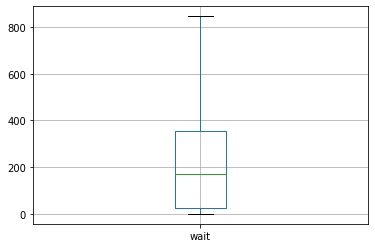

In [6]:
df_2 = interQuartile(df_2)
df_2 = interQuartile(df_2)
df_2 = interQuartile(df_2)
df_2 = interQuartile(df_2)
df_2 = interQuartile(df_2)
df_2 = interQuartile(df_2)
df_2 = interQuartile(df_2)
df_2 = interQuartile(df_2)
df_2 = interQuartile(df_2)
wait_col = ['wait']
df_2.boxplot(wait_col)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


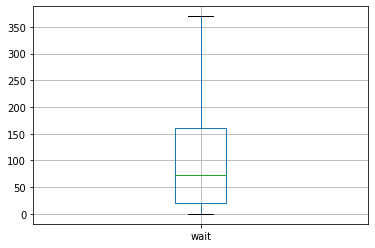

In [11]:
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
df2 = interQuartile(df2)
wait_col = ['wait']
df2.boxplot(wait_col)

### **Azure Dataset for JMeter**

In [8]:
df_2_copy = df_2.copy()
df_2_copy = df_2_copy.drop(['counter', 'DatetimeNumeric', 'wait'], axis=1)
df_2_copy = df_2_copy[::5]
df_2_copy = df_2_copy[::2]
df_2_copy['func'] = '155e47f8e7f751d0c845049456d01832013c61336a8cd85901330ac821a71534'
df_2_copy['counter'] = range(1,len(df_2_copy)+1)
df_2_copy['wait'] = round(df_2_copy['start_timestamp'].diff()*1000,0)
df_2_copy.wait = df_2_copy.wait.fillna(0).astype(int)
df_2_copy.tail()

,app,func,end_timestamp,duration,start_timestamp,date,counter,wait
datetime,,,,,,,,
2021-02-12 17:55:00.016587061,b1034a4b389601e02fcf2318a83a64cc779bf47aa1100a...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.101301e+06,1.131,1.101300e+06,2021-02-12 17:55:00.016587061,2448,55397
2021-02-12 17:55:12.775296999,5fb02cfeb979fec16df02d1ece227157238477b19fc6e3...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.101313e+06,0.124,1.101313e+06,2021-02-12 17:55:12.775296999,2449,12759
2021-02-12 17:56:04.196150885,b81ed828cb5e719288b0c64b3e27bcd36d78d32c4e4565...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.101364e+06,0.015,1.101364e+06,2021-02-12 17:56:04.196150885,2450,51421
2021-02-12 17:58:00.786251957,5fb02cfeb979fec16df02d1ece227157238477b19fc6e3...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.101481e+06,0.093,1.101481e+06,2021-02-12 17:58:00.786251957,2451,116590
2021-02-12 17:58:04.397521881,b81ed828cb5e719288b0c64b3e27bcd36d78d32c4e4565...,155e47f8e7f751d0c845049456d01832013c61336a8cd8...,1.101484e+06,0.021,1.101484e+06,2021-02-12 17:58:04.397521881,2452,3611


In [30]:
df_2_copy.to_csv('gdrive/My Drive/Colab Notebooks/data/Experiment_2_2_AzureDataset.csv', sep=',', encoding='utf-8')

# **Recurrent Neural Networks**

In [14]:
df2 = df2[['wait','DatetimeNumeric']]
df2['hour'] = df2.index.hour
df2['day'] = df2.index.day

# Day
df2['day_sin'] = np.sin(df2.day*(2.*np.pi/30))
df2['day_cos'] = np.cos(df2.day*(2.*np.pi/30))
# Hour
df2['hour_sin'] = np.sin(df2.day*(2.*np.pi/24))
df2['hour_cos'] = np.cos(df2.day*(2.*np.pi/24))
# Minute
df2['minute_sin'] = np.sin(df2.day*(2.*np.pi/60))
df2['minute_cos'] = np.cos(df2.day*(2.*np.pi/60))
df2 = df2.drop(['hour','day','DatetimeNumeric'], axis=1)
df2.tail()

,wait,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos
datetime,,,,,,,
2021-02-12 17:58:04.719836886,118.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017
2021-02-12 17:58:04.797518908,78.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017
2021-02-12 17:58:05.002832901,205.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017
2021-02-12 17:58:05.206281984,203.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017
2021-02-12 17:58:05.408119047,202.0,0.587785,-0.809017,1.224647e-16,-1.0,0.951057,0.309017


In [15]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [17]:
WINDOW_SIZE = 20
X2, y2 = df_to_X_y(df2, WINDOW_SIZE)
X2.shape, y2.shape

((1274108, 20, 7), (1274108,))

In [18]:
X_train2, y_train2 = X2[:1200000], y2[:1200000]
X_val2, y_val2 = X2[1200000:1244010], y2[1200000:1244010]
X_test2, y_test2 = X2[1244010:], y2[1244010:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((1200000, 20, 7),
 (1200000,),
 (44010, 20, 7),
 (44010,),
 (30098, 20, 7),
 (30098,))

In [20]:
temp_training_mean = np.mean(X_train2[:, :, 0])
temp_training_std = np.std(X_train2[:, :, 0])

def preprocessing(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

preprocessing(X_train2)
preprocessing(X_val2)
preprocessing(X_test2)

array([[[ 1.43289865,  0.58778525, -0.80901699, ..., -1.        ,
          0.95105652,  0.30901699],
        [ 0.79697168,  0.58778525, -0.80901699, ..., -1.        ,
          0.95105652,  0.30901699],
        [ 0.01972762,  0.58778525, -0.80901699, ..., -1.        ,
          0.95105652,  0.30901699],
        ...,
        [ 0.13076248,  0.58778525, -0.80901699, ..., -1.        ,
          0.95105652,  0.30901699],
        [ 1.47327496,  0.58778525, -0.80901699, ..., -1.        ,
          0.95105652,  0.30901699],
        [ 1.23101707,  0.58778525, -0.80901699, ..., -1.        ,
          0.95105652,  0.30901699]],

       [[ 0.79697168,  0.58778525, -0.80901699, ..., -1.        ,
          0.95105652,  0.30901699],
        [ 0.01972762,  0.58778525, -0.80901699, ..., -1.        ,
          0.95105652,  0.30901699],
        [-0.89883356,  0.58778525, -0.80901699, ..., -1.        ,
          0.95105652,  0.30901699],
        ...,
        [ 1.47327496,  0.58778525, -0.80901699, ..., -

## **Long Short Term Memory**

In [31]:
model1 = Sequential()
model1.add(InputLayer((X_train2.shape[1],X_train2.shape[2])))
model1.add(LSTM(units=64, activation='relu', stateful=False))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18432     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [32]:
model1.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=5, callbacks=[cp1])

Epoch 1/5
37499/37500 [============================>.] - ETA: 0s - loss: 8053.0112 - root_mean_squared_error: 89.7386

37500/37500 [==============================] - 471s 13ms/step - loss: 8052.9902 - root_mean_squared_error: 89.7385 - val_loss: 9016.9434 - val_root_mean_squared_error: 94.9576
Epoch 2/5
37500/37500 [==============================] - 465s 12ms/step - loss: 7835.6743 - root_mean_squared_error: 88.5193 - val_loss: 9110.9668 - val_root_mean_squared_error: 95.4514
Epoch 3/5
37497/37500 [============================>.] - ETA: 0s - loss: 7791.6182 - root_mean_squared_error: 88.2701

37500/37500 [==============================] - 471s 13ms/step - loss: 7791.7339 - root_mean_squared_error: 88.2708 - val_loss: 8840.3525 - val_root_mean_squared_error: 94.0231
Epoch 4/5
37499/37500 [============================>.] - ETA: 0s - loss: 7766.2461 - root_mean_squared_error: 88.1263

37500/37500 [==============================] - 481s 13ms/step - loss: 7766.2129 - root_mean_squared_error: 88.1261 - val_loss: 8804.8887 - val_root_mean_squared_error: 93.8344
Epoch 5/5
37500/37500 [==============================] - 458s 12ms/step - loss: 7750.8804 - root_mean_squared_error: 88.0391 - val_loss: 8809.9785 - val_root_mean_squared_error: 93.8615


In [33]:
model1 = load_model('model1/')

### **LSTM Train Predictions**

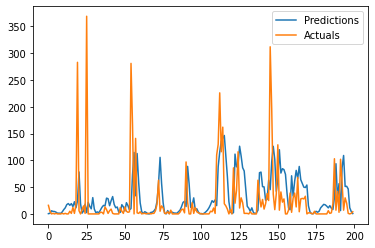

In [34]:
train_predictions1 = model1.predict(X_train2).flatten()
train_results1 = pd.DataFrame(data={'Train Predictions':abs(train_predictions1), 'Actuals':y_train2})
plt.plot(train_results1['Train Predictions'][:200],label="Predictions")
plt.plot(train_results1['Actuals'][:200],label="Actuals")
plt.legend(loc="upper right")

### **LSTM Test Predictions**

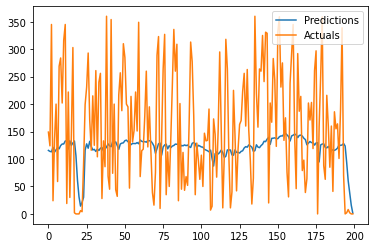

In [35]:
test_predictions1 = model1.predict(X_test2).flatten()
test_results1 = pd.DataFrame(data={'Test Predictions':abs(test_predictions1), 'Actuals':y_test2})
plt.plot(test_results1['Test Predictions'][:200],label="Predictions")
plt.plot(test_results1['Actuals'][:200],label="Actuals")
plt.legend(loc="upper right")

## **Gated Recurrent Unit**

In [22]:
model2 = Sequential()
model2.add(InputLayer((X_train2.shape[1],X_train2.shape[2])))
model2.add(GRU(units=64, activation='relu', stateful=False))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14016     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 14,545
Trainable params: 14,545
Non-trainable params: 0
_________________________________________________________________


In [23]:
model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=5, callbacks=[cp2])

Epoch 1/5
37499/37500 [============================>.] - ETA: 0s - loss: 7956.6992 - root_mean_squared_error: 89.2003

37500/37500 [==============================] - 434s 12ms/step - loss: 7956.7148 - root_mean_squared_error: 89.2004 - val_loss: 9608.3486 - val_root_mean_squared_error: 98.0222
Epoch 2/5
37499/37500 [============================>.] - ETA: 0s - loss: 7789.7476 - root_mean_squared_error: 88.2595

37500/37500 [==============================] - 429s 11ms/step - loss: 7789.7466 - root_mean_squared_error: 88.2595 - val_loss: 8877.6299 - val_root_mean_squared_error: 94.2212
Epoch 3/5
37500/37500 [==============================] - 442s 12ms/step - loss: 7759.1118 - root_mean_squared_error: 88.0858 - val_loss: 8881.8330 - val_root_mean_squared_error: 94.2435
Epoch 4/5
37500/37500 [==============================] - 362s 10ms/step - loss: 7741.4014 - root_mean_squared_error: 87.9852 - val_loss: 9014.2041 - val_root_mean_squared_error: 94.9432
Epoch 5/5
37500/37500 [==============================] - 366s 10ms/step - loss: 7730.0371 - root_mean_squared_error: 87.9206 - val_loss: 8911.1250 - val_root_mean_squared_error: 94.3988


In [26]:
model2 = load_model('model2/')

### **GRU Train Predictions**

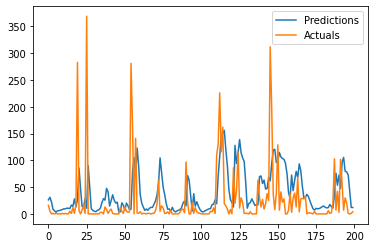

In [27]:
train_predictions2 = model2.predict(X_train2).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions':abs(train_predictions2), 'Actuals':y_train2})
plt.plot(train_results2['Train Predictions'][:200],label="Predictions")
plt.plot(train_results2['Actuals'][:200],label="Actuals")
plt.legend(loc="upper right")

### **GRU Test Predictions**

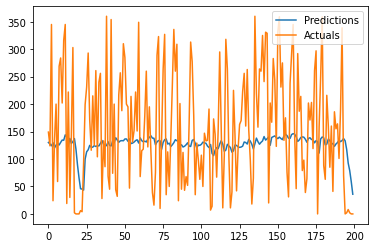

In [28]:
test_predictions2 = model2.predict(X_test2).flatten()
test_results2 = pd.DataFrame(data={'wait':abs(test_predictions2), 'Actuals':y_test2})
plt.plot(test_results2['wait'][:200],label="Predictions")
plt.plot(test_results2['Actuals'][:200],label="Actuals")
plt.legend(loc="upper right")

### **Prediction Dataset for JMeter**

In [29]:
test_results2_copy = (test_results2['wait']*60).astype(int)
test_results2_copy = test_results2_copy[::5]
test_results2_copy = test_results2_copy[::2]
test_results2_copy.to_csv('gdrive/My Drive/Colab Notebooks/data/experiment_2_2_times.csv', sep=',', encoding='utf-8')